# II - Quick Benchmark of Classical Classification Algorithms

In this notebook, we establish benchmark results for predicting the **sentiment** (positive or negative) of movie reviews using classical machine learning algorithms.

These results will serve as a point of comparison to evaluate the performance of **Large Language Models (LLMs)** in the following notebook: `3_prediction_BERT.ipynb`.

The steps are as follows:

### 1 - Building the Vector Representation of Texts

Classical ML algorithms require textual data to be represented as **vectors**. Therefore, the first step is to transform movie reviews into numerical vectors.

Given that the maximum number of words per review is around **2500 words**, we use the **bag-of-words** method, which transforms each review into a vector of size 2500. This is implemented in `scikit-learn` using the `CountVectorizer` function.

However, `CountVectorizer` encodes the text using raw word frequency, which can give excessive weight to frequent words, even if they are not discriminative. To address this, we use **TF-IDF (Term Frequency - Inverse Document Frequency)** weighting, which adjusts word weights based on their frequency across the entire corpus.

In `scikit-learn`, this is implemented with the `TfidfVectorizer` function, which directly produces a bag-of-words representation weighted by TF-IDF.

### 2 - Dimensionality Reduction: Latent Semantic Analysis (LSA)

We follow one of the approaches described in the paper *Learning Word Vectors for Sentiment Analysis* by Maas et al. (2011), applying dimensionality reduction to the term-document matrices using **Singular Value Decomposition (SVD)**. This technique is also known as **Latent Semantic Analysis (LSA)** and helps capture latent semantic structures in the data.

### 3 - Training Classification Algorithms

Using the obtained vector representations, we compare the performance of two classification algorithms:

- `LogisticRegression`: a linear classifier that estimates class probabilities using the logistic function.
- `SVC`: a support vector classifier, well-suited for binary classification tasks and optimized based on the hyperparameters `C` and `kernel`.

These models are trained on the `df_train` set, using **cross-validation** to select the optimal value of certain **hyperparameters** from a grid:

- `C` for the `LogisticRegression` model, which controls the level of regularization,
- `C` and `kernel` for the `SVC`, where `C` controls the regularization strength and `kernel` determines the type of kernel function used.


### 4 - Performance Evaluation

Once the models are trained, we evaluate them on the `df_test` set. We compare the performance by generating **confusion matrices** and **classification reports**, which display the precision, recall, and F1-score for each class (positive/negative).

----

In [2]:
"""Importation of librairies"""
# Standard library
import os
import tarfile
import urllib.request
import joblib

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn modules
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [3]:
# loading train and test data
df_train = pd.read_parquet("data/df_train.parquet")
df_test = pd.read_parquet("data/df_test.parquet")

In [4]:
X_train = df_train['texte']
y_train = df_train['label']
X_test = df_test['texte']
y_test = df_test['label']

#### Pipelines definition

In [12]:
"""Define the different pipelines"""

# pipeline with tf-idf + svd (lsa) + logistic regression
pipeline_logistic = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=2500)),
    ('svd', TruncatedSVD(n_components=100, random_state=42)),
    ('clf', LogisticRegression(max_iter=300))
])

# pipeline with tf-idf + svd + support vector classifier
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(n_components=100, random_state=42)),
    ('clf', SVC())
])

In [15]:
"""Grids for hyperparameter search during cross-validation"""

# grid search for logistic regression
param_grid_logistic = {
    'clf__C': [0.01, 0.1, 1, 10]
}

# grid for svc
param_grid_svc = {
    'clf__C': [0.1, 1.0, 10.0],
    'clf__kernel': ['linear', 'rbf']
}

#### Logistic regression model

In [ ]:
"""Training the logistic regression model"""

grid_logistic = GridSearchCV(pipeline_logistic, param_grid_logistic, cv=3, scoring='accuracy')
grid_logistic.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=2500,
                                                        stop_words='english')),
                                       ('svd',
                                        TruncatedSVD(n_components=100,
                                                     random_state=42)),
                                       ('clf',
                                        LogisticRegression(max_iter=300))]),
             param_grid={'clf__C': [0.01, 0.1, 1, 10]}, scoring='accuracy')

In [ ]:
# saving the trained model

model_filename = "models/logistic_regression_tfidf_svd_gridsearch.joblib"
joblib.dump(grid_logistic, model_filename)
print(f"Modèle enregistré sous : {model_filename}")

Modèle enregistré sous : models/logistic_regression_tfidf_svd_gridsearch.joblib


logistic regression - best params: {'clf__C': 10}
classification report - logistic regression:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85     12500
           1       0.85      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

confusion matrix - logistic regression:
 [[10564  1936]
 [ 1757 10743]]


<Figure size 800x600 with 0 Axes>

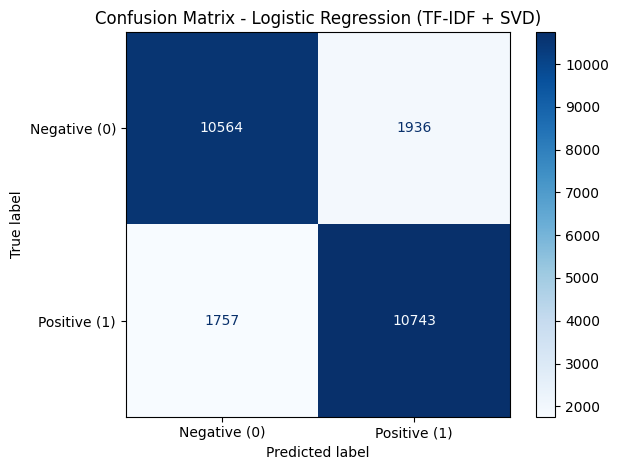

In [5]:
"""Evaluation of the model"""

# load the model
grid_logistic = joblib.load("models/logistic_regression_tfidf_svd_gridsearch.joblib")

# make predictions on the test set
y_pred_logistic = grid_logistic.predict(X_test)

# show results
print("logistic regression - best params:", grid_logistic.best_params_)
y_pred_logistic = grid_logistic.predict(X_test)
print("classification report - logistic regression:\n", classification_report(y_test, y_pred_logistic))
print("confusion matrix - logistic regression:\n", confusion_matrix(y_test, y_pred_logistic))

# plot and save the confusion matrix
cm = confusion_matrix(y_test, y_pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative (0)', 'Positive (1)'])

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Logistic Regression (TF-IDF + SVD)')
plt.tight_layout()  # <-- Ajout ici pour éviter de couper les éléments
plt.savefig('output/confusion_matrix_logistic.png', dpi=300)
plt.show()

#### Naive Bayes classifier model

In [16]:
"""Training the SVC model"""

grid_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=3, scoring='accuracy')
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('svd',
                                        TruncatedSVD(n_components=100,
                                                     random_state=42)),
                                       ('clf', SVC())]),
             param_grid={'clf__C': [0.1, 1.0, 10.0],
                         'clf__kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [17]:
# saving the trained model

model_filename = "models/svc_svd_gridsearch.joblib"
joblib.dump(grid_svc, model_filename)
print(f"Modèle enregistré sous : {model_filename}")

Modèle enregistré sous : models/svc_svd_gridsearch.joblib


SVC - best params: {'clf__C': 1.0, 'clf__kernel': 'rbf'}
classification report - SVC :
               precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

confusion matrix - SVC :
 [[10807  1693]
 [ 1787 10713]]


<Figure size 800x600 with 0 Axes>

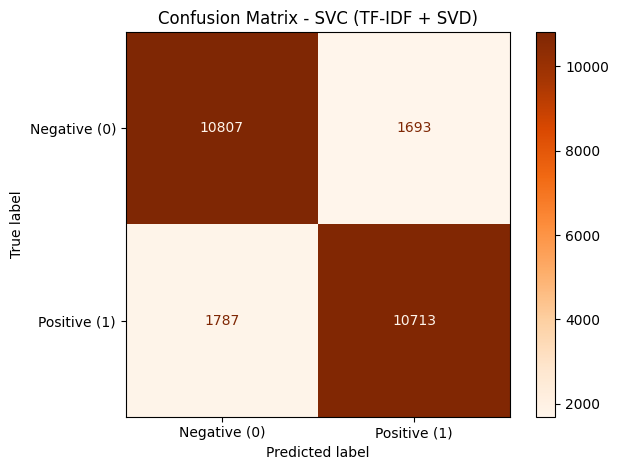

In [6]:
"""Evaluation of the model"""

# load the model
loaded_model = joblib.load("models/svc_svd_gridsearch.joblib")

# make predictions on the test set
y_pred_nb = loaded_model.predict(X_test)

# show results
print("SVC - best params:", loaded_model.best_params_)
print("classification report - SVC :\n", classification_report(y_test, y_pred_nb))
print("confusion matrix - SVC :\n", confusion_matrix(y_test, y_pred_nb))

# plot and save the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative (0)', 'Positive (1)'])

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Oranges, values_format='d')
plt.title('Confusion Matrix - SVC (TF-IDF + SVD)')
plt.tight_layout()  # <-- Ajout ici pour éviter de couper les éléments
plt.savefig('output/confusion_matrix_svc.png', dpi=300)
plt.show()